<img src="data/logo-ensae.jpg"> <img src="data/logo-ipparis.jpg">

**"Techniques Avancées d'apprentissage", S2 2018-19** 
# *One-class Classification with Support Vector Machine*  

  
**Tanguy CARROUSSEL**, *Mastère Spécialisé Data Science, ENSAE ParisTech*  
**Yosuke IJIRI**, *Mastère Spécialisé Data Science, ENSAE ParisTech*  

# Overview
- This is the coding part of the project. Report is prepared separately from this notebook.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
import numpy as np
import random
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import utils.mnist_reader as mnist_reader
import utils.tools as tls
import PIL.Image

## 1. Data

 - We use fashion-mnist data (source: https://github.com/zalandoresearch/fashion-mnist).
 - There are 60000 train data and 10000 test data; each of the data (item) respresents a set of 28*28 (784) pixels with gray scale ranging from 0 to 255.
 - Since we use unsupervised learning, we can concatenate train and test set into one large set.

In [3]:
# Load the dataset
X_train, y_train = mnist_reader.load_mnist('./data', kind='train')
X_test, y_test = mnist_reader.load_mnist('./data', kind='t10k')
X, y = np.concatenate((X_train, X_test), axis = 0), np.concatenate((y_train, y_test), axis = 0)
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

Shape of X:  (70000, 784)
Shape of y:  (70000,)


In [4]:
label_dic = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
             5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

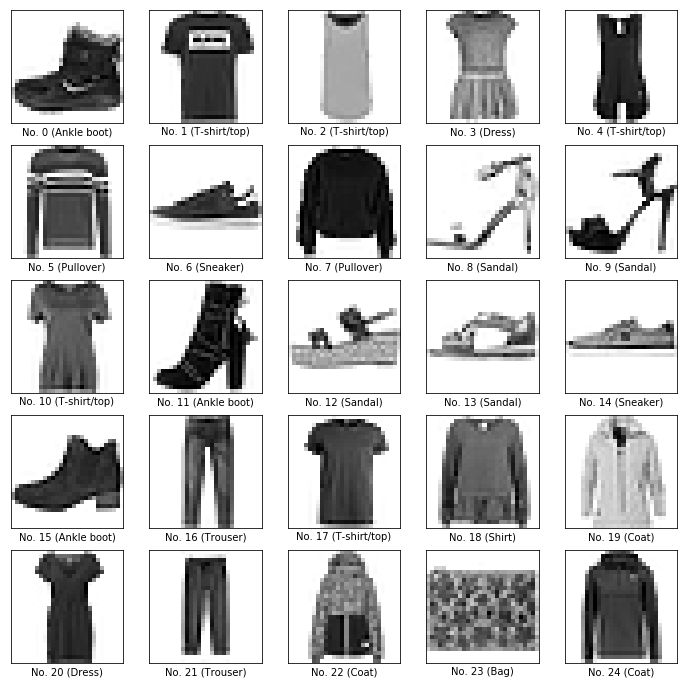

In [5]:
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([]), plt.yticks([])
    plt.xlabel("No. %d (%s)" %(i, label_dic[y_train[i]]))
    plt.imshow(X[i].reshape(28,28), cmap=plt.cm.binary)
plt.savefig('./mnist/visualization/samples.png')
#tls.save_image("./mnist/visualization/sample.png", X_train[0]) would be better to save sample outputs
#PIL.Image.fromarray(X_train.reshape((X_train.shape[0],28,28))[0]) is the visualisation part of the above saving code

- Create a dictionary that holds index information for each label.

In [6]:
idx_dic = {}
for i in range(10):
    idx_dic[i] = [idx for idx, label in enumerate(y) if label == i]

- Visualise sample images for each fashion item.

There are 7000 images of T-shirt/top.
There are 7000 images of Trouser.
There are 7000 images of Pullover.
There are 7000 images of Dress.
There are 7000 images of Coat.
There are 7000 images of Sandal.
There are 7000 images of Shirt.
There are 7000 images of Sneaker.
There are 7000 images of Bag.
There are 7000 images of Ankle boot.


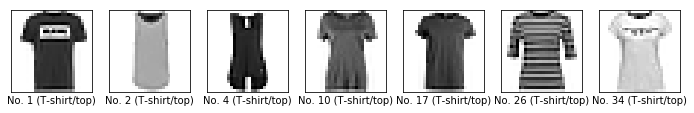

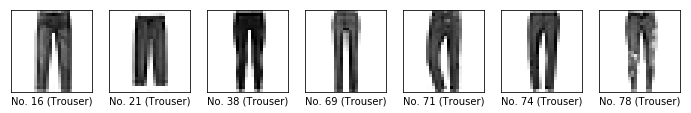

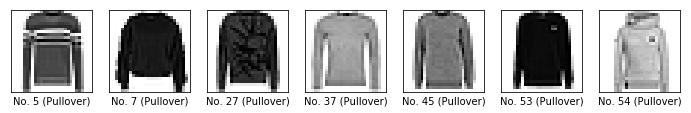

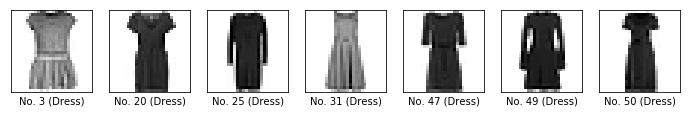

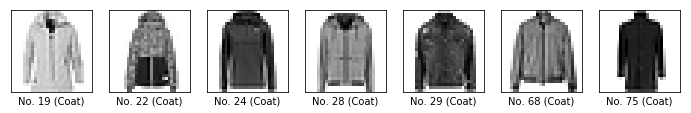

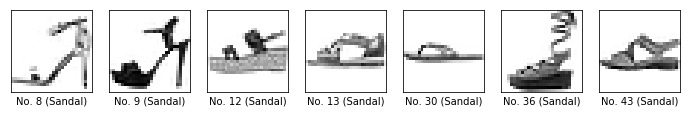

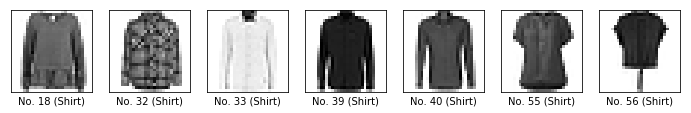

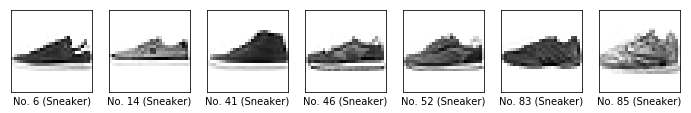

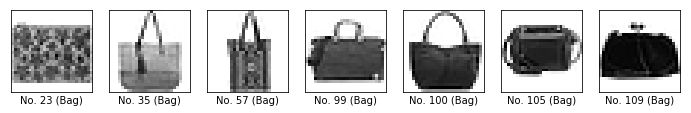

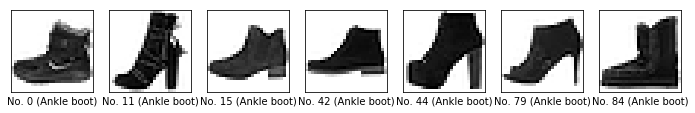

In [7]:
for i in range(10):
    print('There are %d images of %s.' %(len(idx_dic[i]), label_dic[i]))
    plt.figure(figsize=(12,12))
    for j in range(7):
        plt.subplot(1, 7, j+1)
        plt.xticks([]), plt.yticks([])
        plt.xlabel('No. %d (%s)' %(idx_dic[i][j], label_dic[i]))
        plt.imshow(X[idx_dic[i]][j].reshape(28,28), cmap=plt.cm.binary)
    plt.savefig('./mnist/visualization/sample_%d.png' %i)

## 2. Model

* One-class SVM  
https://scikit-learn.org/0.15/modules/generated/sklearn.svm.OneClassSVM.html

In [76]:
from sklearn import svm

In [228]:
X0 = X[idx_dic[0]] / 255.0  # Normalise the data (To check if this is really effective or not)

In [234]:
clf = svm.OneClassSVM(kernel='rbf',
                      nu=0.01, 
                      degree=3,  # Only for ‘poly’; 3 by default
                      gamma='auto',  # Only for ‘rbf’, ‘poly’ and ‘sigmoid; 'auto' or float
                      coef0=0.0)  # Only for ‘poly’ and ‘sigmoid’; 0.0 by default
clf.fit(X0)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.01, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

[MEMO]
- (T-shirt, rbf) detects outliers to be eccentric-shaped T-shirts.
- (T-shirt, linear/poly/sigmoid) detects outliers to be white (light colour) T-shirts.

| T-shirt | nu | degree | gamma | coef0 |
|---|---|---|---|---|
| linear |0.01|×|×|×|
| poly |0.01|3|auto|0.0|
| rbf |0.01|×|auto (#anomalies increases if >> 0)|×|
| sigmoid |0.01|×|auto|0.0|

In [235]:
y_pred = clf.predict(X0)

In [236]:
predicted_outlier_index = np.where(y_pred == -1)  # Extract anomalies
predicted_normal_index = np.where(y_pred == 1)
predicted_outlier = X0[predicted_outlier_index]
len(predicted_outlier)

74

## 3. Result

### Visualisation of sample anomaly images
- We can see that sample T-shirt images predicted to be anomaly have indeed eccentric shape as a T-shirt. (Compare with the images of T-shirt that were predicted to be normal in the cell next.)

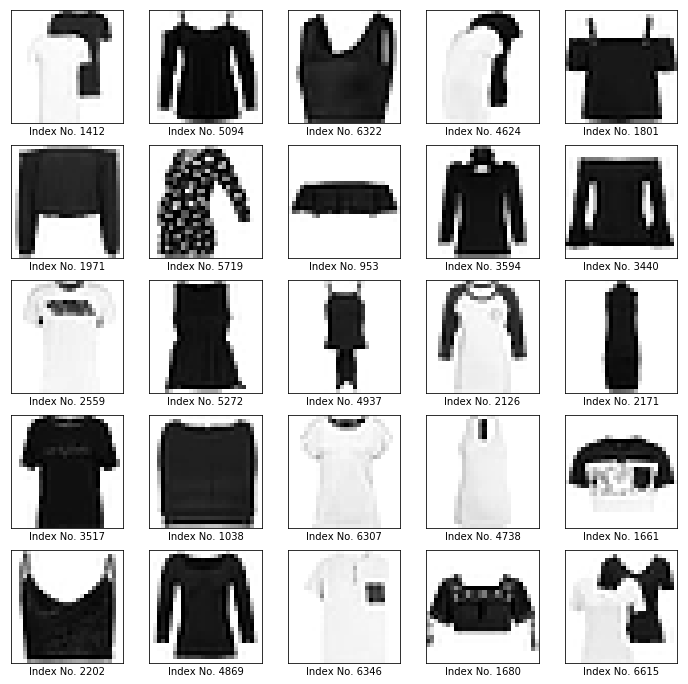

In [237]:
sample_idx = random.sample(list(predicted_outlier_index[0]), 25)
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([]), plt.yticks([])
    plt.xlabel("Index No. %d" %sample_idx[i])
    plt.imshow(X0[sample_idx][i].reshape(28,28), cmap=plt.cm.binary)
plt.savefig('./mnist/visualization/anomalies.png')

- Compare with the below sample images that were predicted to be normal. These indeed look regular styles of T-shirt to us.

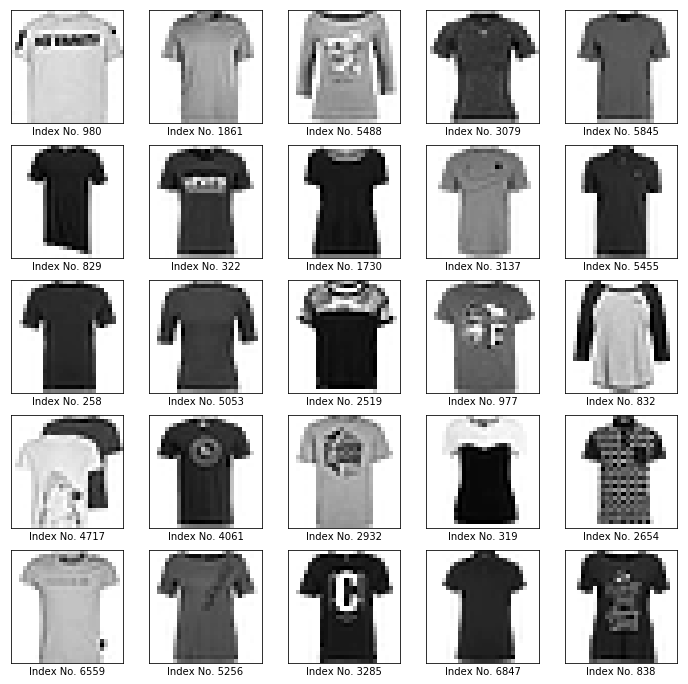

In [239]:
sample_idx = random.sample(list(predicted_normal_index[0]), 25)
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([]), plt.yticks([])
    plt.xlabel("Index No. %d" %sample_idx[i])
    plt.imshow(X0[sample_idx][i].reshape(28,28), cmap=plt.cm.binary)
plt.savefig('./mnist/visualization/normal.png')

[MEMO] We might be able to put all the data (T-shirt, Sandal, etc.) into the same model. In this case, according to the paper, the dimentionality is 10 (number of different labels). But I am not sure yet.

- Please refer to our report for conclusion.